# Paper Image Generation

This notebook contains the code to generate all of the Floquet related plots from the paper.

In [4]:
# Imports 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import stim 
import pymatching as pm
import pickle
import json
import matplotlib as mpl

import src.layout_templates as templates
from src.CSS_direct import Hex_Code
from src.qiskit_glue import Cross_Platform_Code, add_calibration_noise
import src.results_processing as rp
from src.device_mapping import check_alignment
from src.tools import plot_simulation_comparison

## Defining a Code

There are a few steps to defining a floquet code using the framework defined here. First a layout needs to be defined. Here the layout is printed with + signs as data qubits, and the ancillas labelled in the color and Pauli associated with the link operator. The logical observable is defined along the yellow + data qubits, and the highlights are meant to show the color associated of the plaquettes formed. Highlights can be added in yellow, here we highlight the upper left most qubit, which is the qubit that defines where the code will be placed on a real chip.

In [5]:
size = 3
basis = 'primary' # primary or dual

layout = templates.diamond(size, basis=basis, noise=2e-2*np.ones(5))
layout.print(borders=True, observable=True,
             highlights=[layout.index_from_coord(6, 2)])

y\x 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 
1                               
2           + X + Y +           
3       m   Y       X   e       
4       + Z + X + Y + Z +       
5   m   X       Z       Y   e   
6   + Y + Z + X + Y + Z + X +   
7   Z       Y       X       Z   
8   + Y + Z + X + Y + Z + X +   
9   e   X       Z       Y   m   
0       + Z + X + Y + Z +       
1       e   Y       X   m       
2           + X + Y +           
3                               
4                   


We then define a '''Hex_Code''', which is where lots of useful objects like a stim circuit or a pymatching matching graph is stored. Due to how things were developed, we have yet another object called a '''Cross_Platform_Code''' which contains a qiskit circuit that can be used to run the code on an IBM Quantum device. The location argument can be used to move the layout around on a physical chip.

In [6]:
sub_rounds = 16
location = 4
chip_size = 127     # Eagle device size

hex_code = Hex_Code(layout, sub_rounds)
cross_code = Cross_Platform_Code(hex_code, chip_size, location)

Lets run a quick simulation and see how this code would fit on a chip. I will not go into length about how this specific software setup works, because I think only about two people will end up reading this.

In [7]:
shots = int(2**14)

detectors, logical_operators = cross_code.sample(shots)
e_heat, m_heat = rp.get_em_heatmaps(cross_code, detectors)

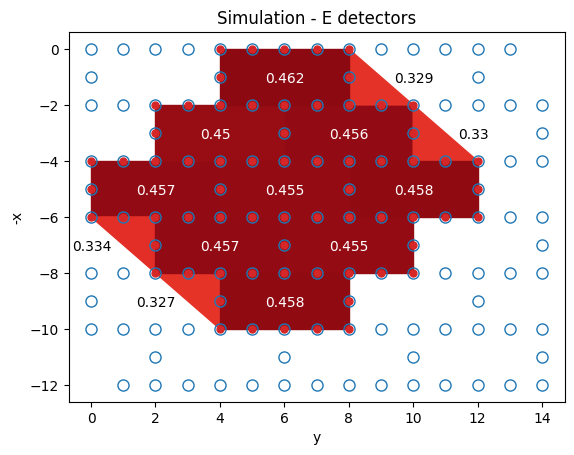

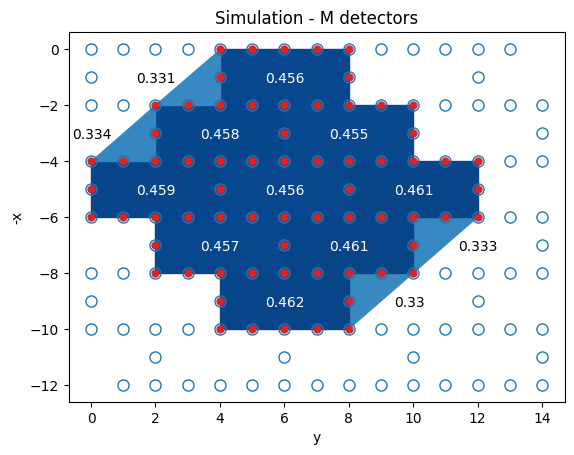

In [8]:
check_alignment(cross_code.map, cross_code.layout, 
                heatmap=e_heat, cmap_key="Reds", noise_coloring='half',
                title='Simulation - E detectors')
check_alignment(cross_code.map, cross_code.layout, 
                heatmap=m_heat, cmap_key="Blues", noise_coloring='half',
                title='Simulation - M detectors')

## Figure 1: Detector Likelihood Threshold

In [9]:
noises = np.linspace(1e-3,3e-3,10)
noise_breakdown = np.ones(5)
shots = int(1e5)
sizes = list(range(7,23,4))[::-1] #[14, 11, 8, 5]
basis = 'primary'
distances = []

data = []
for d in range(len(sizes)):
    dats = []
    for n in noises:
        noise = n * np.array(noise_breakdown)
        subrounds = 2 * sizes[d]

        layout = templates.diamond(sizes[d], noise=noise, basis=basis)
        hex_code = Hex_Code(layout, subrounds)

        #error_rate = error_rate_sim(hex_code, shots)
        detectors, logical_ops = hex_code.sample(shots)

        errors = 0
        e_avgs_sum = 0
        for s in range(shots):
            correction = hex_code.match.decode(detectors[s])
            if correction != logical_ops[s]:
                errors += 1
        error_rate = errors / shots

        e_heats, m_heats = rp.get_em_heatmaps(hex_code, detectors,include_timelike_truncs=False, include_spatial_truncs=False)
        e_avg = sum([e_heats[key] for key in e_heats]) / len(e_heats)

        dats.append((e_avg, error_rate))
        print('.', end='')
    distances.append(len(hex_code.circuit.shortest_graphlike_error()))
    data.append(dats)
    print('!', end='')
    print(sizes[d], dats)

print(data)

..........!19 [(0.056429228993536425, 0.0), (0.06807391966759005, 7e-05), (0.07943015235457063, 0.0003), (0.09051396121883656, 0.00142), (0.10130507848568789, 0.00507), (0.1118003601108034, 0.01346), (0.12199078947368425, 0.03123), (0.13196379501385044, 0.06531), (0.14159181902123735, 0.11164), (0.1510684441366574, 0.17501)]
..........!15 [(0.056371813333333326, 0.0), (0.06804628888888888, 0.00017), (0.07939608888888888, 0.0008), (0.09049322222222224, 0.00246), (0.10123127333333333, 0.00573), (0.11176376444444434, 0.01396), (0.12184617555555548, 0.02758), (0.13190496444444447, 0.05062), (0.14159628666666668, 0.08354), (0.15097592222222225, 0.12499)]
..........!11 [(0.05631170798898073, 0.00016), (0.06797865013774104, 0.00063), (0.07944730716253441, 0.00174), (0.09049849173553719, 0.00342), (0.1010757713498622, 0.00789), (0.11163782369145998, 0.01513), (0.12178373278236912, 0.02514), (0.13187198347107434, 0.03995), (0.1415490840220386, 0.06056), (0.1507469903581266, 0.08478)]
..........

In [159]:
# with open("simulation_data/threshold_data_2dsubrounds_DLv2.obj", 'wb') as f:
#     pickle.dump({'data': data,'distances': distances,'sizes': sizes, 'noises':noises ,'shots': shots}, f)

In [10]:
# with open(r"simulation_data/threshold_data_4dsubrounds.obj", "rb") as input_file:
with open(r"simulation_data/threshold_data_2dsubrounds_DLv2.obj", "rb") as input_file:
    data_dict = pickle.load(input_file)
data = data_dict['data']
noises = data_dict['noises']
sizes = data_dict['sizes']
distances = data_dict['distances']
shots = data_dict['shots']

In [11]:
def fit_func(vars,data,d_list,DLmax = 0.1):
    pth,PLth = vars
    cost = 0
    for di,dd in enumerate(d_list):
        DL_list, PL_list  =  np.transpose(data[di])
        DL_list, PL_list  =  np.transpose([(DL,PL) for DL,PL in zip(DL_list, PL_list) if DL<DLmax])
        PL_anal = PLth*(DL_list/pth)**int((dd+1)/2)
        cost+=np.mean(abs(PL_list-PL_anal)/(PL_list+PL_anal))
    return cost

0.11455630302429212 0.01517885208129886


<Figure size 640x480 with 0 Axes>

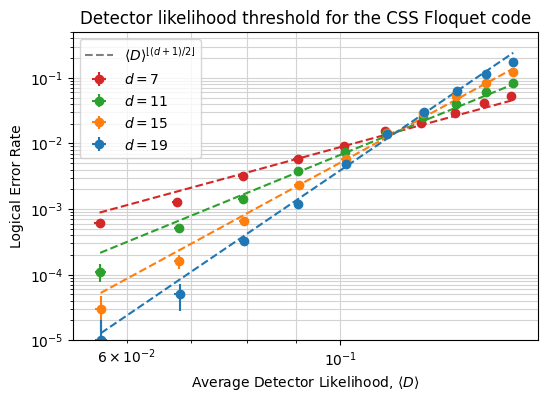

In [12]:
from scipy.optimize import minimize
DLth,PLth = minimize(fit_func,[0.1,0.05], args = (data,distances,0.13), method='Nelder-Mead', tol = 1e-3).x

print(DLth,PLth)

plt.clf()
fig, ax = plt.subplots(1, 1, figsize = (6,4))
for d in range(len(distances)-1,-1,-1):
    dets, ers = np.transpose(data[d])
    plt.errorbar(dets, ers, yerr=np.sqrt(ers*shots)/shots, xerr=np.sqrt(dets*shots)/shots, marker = 'o', linestyle=' ', color=f'C{d}',label=f'$d={distances[d]}$')
    plt.plot(dets, PLth*(dets/DLth)**int((distances[d]+1)/2),'--', color=f'C{d}')
ax.loglog()
ax.set_title('Detector likelihood threshold for the CSS Floquet code')
ax.set_xlabel(r"Average Detector Likelihood, $\langle D\rangle$")
ax.set_ylabel("Logical Error Rate")
ax.grid(which='both', color='lightgray')
# if DLth is not None:
#     ax.vlines(DLth, 
#                 1/shots, PLth, 
#                 linestyles='dashed', color='gray', alpha = 0.6,
#                 # label=r'$P_{th}$'f' = {round(100*DLth,2)}%'
#                 )
plt.axhline(1.1,linestyle = '--',c='gray', label = r'$\langle D\rangle^{\lfloor (d+1)/2 \rfloor}$')
ax.set_ylim(1e-5,.5)
# fig.set_dpi(120) 
ax.legend()
# plt.savefig("paper_images/D_threshold_Floquet.pdf")
plt.show()

## Figure 2: Real Device over simulation data


Here we plot simulation data and real device data as a function of average detector likelihood.

Processed results already exist in the Results/ folder for the real device. The first cell here is to get the simulation data, but that can easily be skipped and the next cell can be used. It has data from a previously done simulation.

In [13]:
from src.simulation import error_rate_sim

# Select number of sub-rounds (even number between 4 and 16 inclusive, 4 and 10 for Torino data)
num_sub_rounds = 4
assert num_sub_rounds % 2 == 0 and 4 <= num_sub_rounds <= 16, 'Must be even number between 4 and 16 inclusive.'

# Simulation
shots = int(1e5)
noises = [ 1.5e-2, 1.75e-2, 2e-2, 2.25e-2,  2.5e-2, 3e-2, 4e-2, 6e-2]
sizes = [8, 5, 3, 2]
sher_med_noise = [1e-2, 2e-3, 1e-2, 1e-3, 7e-3]
ms = False if num_sub_rounds == 4 else True

e_likelihoods = np.empty((len(sizes),len(noises)))
m_likelihoods = np.empty((len(sizes),len(noises)))
error_rates = np.empty((len(sizes),len(noises)))
for s in range(len(sizes)):
    for n in range(len(noises)):
        # Defining code
        layout = templates.diamond(sizes[s], noise=noises[n]*np.ones(5))
        code = Hex_Code(layout, sub_rounds=num_sub_rounds)

        # Simulating
        detectors, log_ops = code.sample(shots)
        error_rate = error_rate_sim(code, shots)
        
        e_map, m_map = rp.get_em_heatmaps(code, detectors)
        e_avg = sum([e_map[key] for key in e_map]) / len(e_map)
        if ms:
            m_avg = sum([m_map[key] for key in m_map]) / len(m_map)

        # Storing results
        e_likelihoods[s][n] = e_avg
        if ms:
            m_likelihoods[s][n] = m_avg
        error_rates[s][n] = error_rate
        print('.', end='')
    print(',', end='')
error_rates, e_likelihoods

# Note: this is flat noise model
# Expected sim time (for 6 sub-rounds) ~6.5 min

....

KeyboardInterrupt: 

In [14]:
# Saved results for a longer run sim. For 4 sub-rounds

error_rates, e_likelihoods = [[0.35447, 0.41633, 0.4546 , 0.47854, 0.48482, 0.49717, 0.49655,
         0.50293],
        [0.30986, 0.36599, 0.412  , 0.44051, 0.46352, 0.48331, 0.4997 ,
         0.49999],
        [0.27998, 0.32455, 0.36469, 0.39736, 0.42177, 0.45882, 0.4861 ,
         0.49697],
        [0.26089, 0.30276, 0.33807, 0.36699, 0.39187, 0.43016, 0.47068,
         0.49507]],[[0.34523795, 0.37150256, 0.39251641, 0.41004769, 0.42438769,
         0.44592821, 0.47133808, 0.49070667],
        [0.33708788, 0.36337364, 0.38427273, 0.40161121, 0.41677667,
         0.44008121, 0.46651788, 0.48816   ],
        [0.32676692, 0.35280462, 0.37457308, 0.39239154, 0.40666231,
         0.43059   , 0.46055538, 0.48512615],
        [0.32572667, 0.35147833, 0.37380667, 0.39322167, 0.40708   ,
         0.43107   , 0.461585  , 0.48643833]]

num_sub_rounds = 4
shots = int(1e5)
noises = [ 1.5e-2, 1.75e-2, 2e-2, 2.25e-2,  2.5e-2, 3e-2, 4e-2, 6e-2]
sizes = [8, 5, 3, 2]
sher_med_noise = [1e-2, 2e-3, 1e-2, 1e-3, 7e-3]

In [15]:
file = 'Results/first_pass_data.json'

num_sub_rounds = 4
shots = int(1e5)
noises = [ 1.5e-2, 1.75e-2, 2e-2, 2.25e-2,  2.5e-2, 3e-2, 4e-2, 6e-2]
sizes = [8, 5, 3, 2]
sher_med_noise = [1e-2, 2e-3, 1e-2, 1e-3, 7e-3]

# Pulling Real Device Data
size_2_runs = rp.gather_run_data(file_name=file,
                                subrounds=[num_sub_rounds],
                                basis=['primary'],
                                size=[2])
size_3_runs = rp.gather_run_data(file_name=file,
                                subrounds=[num_sub_rounds],
                                basis=['primary'],
                                size=[3])


e_likelihoods_device_2 = []
error_rates_device_2 = []
shots_2 = []
for run in size_2_runs:
    e_likelihoods_device_2.append(run['e_likelihood'])
    error_rates_device_2.append(run['error_rate'])
    shots_2.append(run['shots'])

e_likelihoods_device_3 = []
error_rates_device_3 = []
shots_3 = []
for run in size_3_runs:
    e_likelihoods_device_3.append(run['e_likelihood'])
    error_rates_device_3.append(run['error_rate'])
    shots_3.append(run['shots'])



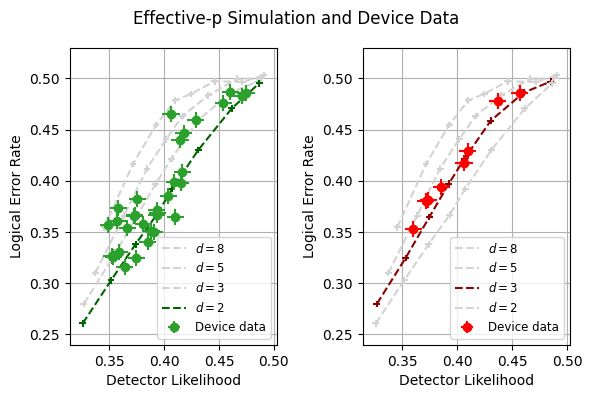

In [16]:
# Plotting
fig = plt.figure(figsize=(6, 4))
plt.suptitle(r'Effective-p Simulation and Device Data')# ({num_sub_rounds} subrounds)')

##### SIZE 2 ####
plt.subplot(121)
# Plotting Simulation Data
colored_size = 2
highlight_color = 'darkgreen'
for s in range(len(sizes)):
    # Setting Color
    if sizes[s] == colored_size:
        color = highlight_color
    else:
        color = 'lightgrey'
    # Plotting Data
    plt.plot(e_likelihoods[s], error_rates[s], '--', label=f'$d =  {sizes[s]}$', color=color)
    plt.errorbar(e_likelihoods[s], error_rates[s], yerr=1/np.sqrt(shots), xerr=1/np.sqrt(shots), linestyle=' ',color=color)

# Plotting Real Device Data
plt.errorbar(e_likelihoods_device_2, error_rates_device_2, xerr=1/np.sqrt(shots_2), yerr=1/np.sqrt(shots_2),marker = 'o', linestyle=' ', color='tab:green', label = r'Device data')

# Nicities
plt.grid()
plt.xlabel(r'Detector Likelihood')
plt.ylabel(r'Logical Error Rate')
#plt.title('Flat noise model simulation vs Real Device Data')
plt.legend(fontsize = 8.5)
plt.ylim(.24, .53)


##### SIZE 3 #####
plt.subplot(122)

# Plotting Simulation Data
colored_size = 3
highlight_color = 'darkred'
for s in range(len(sizes)):
    # Setting Color
    if sizes[s] == colored_size:
        color = highlight_color
    else:
        color = 'lightgrey'
    # Plotting Data
    plt.plot(e_likelihoods[s], error_rates[s], '--', label=f'$d =  {sizes[s]}$', color=color)
    plt.errorbar(e_likelihoods[s], error_rates[s], yerr=1/np.sqrt(shots), xerr=1/np.sqrt(shots), linestyle=' ',color=color)

# Plotting Real Device Data
plt.errorbar(e_likelihoods_device_3, error_rates_device_3, xerr=1/np.sqrt(shots_3), yerr=1/np.sqrt(shots_3), marker = 'o', linestyle=' ', color=f'red', label = r'Device data')

# Nicities
plt.grid()
plt.xlabel(r'Detector Likelihood')
plt.ylabel(r'Logical Error Rate')
#plt.title('Flat noise model simulation vs Real Device Data')
plt.legend(fontsize = 8.5)
plt.ylim(.24, .53)


plt.tight_layout(pad=1)

# plt.savefig("paper_images/LE_DL_real_vs_sim.pdf")
plt.show()


<Figure size 640x480 with 0 Axes>

## Figure 3: p_eff fitting

Here we need to simulate different noise levels of different sub-rounds and distances, then fit them with the proper curve.

In [17]:
f = open("simulation_data/p_eff_fitting_data.obj", "rb")
raw_data_no_spatial_truncs = pickle.load(f)
f.close()

noises = [5e-2, 4e-2, 3e-2, 2e-2, 1e-2, 6.5e-3, 3.3e-3, 2e-3, 1e-3]
sizes = [11, 8, 5, 3, 2]
sub_rounds = list(np.arange(4,17,2))
shots = int(1e5)

In [18]:
def p_eff_fitting(alpha, D_avg):
    return (1 - np.exp(-alpha * D_avg)) / 2

In [19]:
# Getting fits from data
size_fits_no_truncs = {size: {sr: {} for sr in sub_rounds} for size in sizes}
for s in range(len(sizes)):
    for srs in range(len(sub_rounds)):

        params_no, covar_no = curve_fit(p_eff_fitting, noises, raw_data_no_spatial_truncs[s][srs])
        alpha_no = params_no[0]
        error_no = np.sqrt(covar_no[0][0])
        size_fits_no_truncs[sizes[s]][sub_rounds[srs]] = {'alpha': alpha_no, 'error': error_no}

print('done.')

done.


In [20]:
def p_eff(D_avg, alpha=119):
    # if D_avg > .49999:
    #     return .5
    # else:
    return - np.log(1 - 2 * D_avg) / alpha

In [21]:
raw_data_no_spatial_truncs[s][sub_rounds.index(sr)]

NameError: name 'sr' is not defined

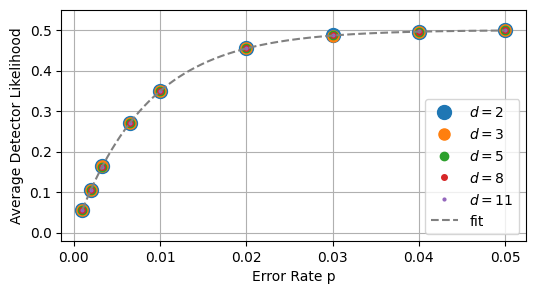

In [22]:
# Define number of subrounds to be plotted for all sizes
sr = 14
sizes = [11, 8, 5, 3, 2]
plt.figure(figsize=(6,3))
for sr in [16]:#[4,6,8,10,12,14,16]:
    fitting = np.linspace(.001, .05, 1000)
    for s in sizes[::-1]:
        plt.plot(noises, raw_data_no_spatial_truncs[sizes.index(s)][sub_rounds.index(sr)], 'o', markersize=2*(1+sizes.index(s)), label=f'$d = {s}$', color=f'C{len(sizes)-1-sizes.index(s)}')
        plt.errorbar(noises, raw_data_no_spatial_truncs[sizes.index(s)][sub_rounds.index(sr)], yerr=1/np.sqrt(shots), linestyle=' ',color=f'C{len(sizes)-1-sizes.index(s)}')


alpha = size_fits_no_truncs[sizes[sizes.index(s)]][sr]['alpha']
plt.plot(fitting, p_eff_fitting(np.array(fitting), alpha), '--',lw = 1.5, color=f'gray', label=r'fit')

plt.legend()
plt.xlabel(r'Error Rate p')
plt.ylabel(r'Average Detector Likelihood')
# plt.title(f'Effective Flat Error Rate p vs Average Detector Likelihood')
#plt.xscale('log')
plt.grid(which='both')
#plt.hlines([.35, .42], 1e-3, 5e-2, linestyles='dashed', color='lightgray')
#plt.vlines([.013, .02], .05, .5, linestyles='dashed', color='lightgray')
# plt.loglog()
plt.ylim(-0.02,0.55)
# plt.savefig("paper_images/p_eff_fitting.pdf", bbox_inches = 'tight')
plt.show()

## Figure 4: Simulation Comparison Examples

Here we load the processed data from a json folder containing the error rates for different runs on Sherbrooke. There is a cutoff post select to get ride of noise soup data points, then simulating and plotting the data using existing simulaiton and plotting methods.

In [23]:
data_set = rp.get_error_rate_per_round_data(file_name='Results/first_pass_data.json')

cutoff = .48
filtered_set = [data for data in data_set 
                 if data['data']['average_detector_likelihood'] < cutoff]
print(len(data_set), '->', len(filtered_set))

80 -> 67


c:\Users\Ian\Downloads\Ian_upload\Ian_upload\src\results_processing.py:424: OptimizeWarning: Covariance of the parameters could not be estimated
  fit, covar = curve_fit(log_er_per_round, sub_rounds, error_rates)


Siming.......,


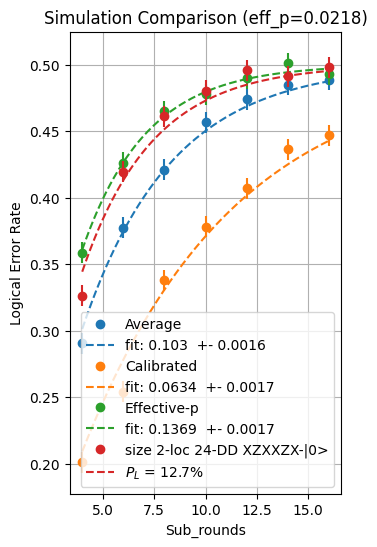

In [24]:
example_index = 47
sim_fits = rp.get_simulation_comparison(data_set[example_index], backend="sherbrooke", printing=True, shots=int(2**14))
plot_simulation_comparison(data_set[example_index], sim_fits, fig_size=(3.5,6))

In [183]:
[(i, data_set[i]['meta_data']) for i in [21,67,47]]

[(21,
  {'date': '20231106',
   'device': 'sherbrooke',
   'size': 2,
   'location': 20,
   'basis': 'dual',
   'DD': 'XXXX'}),
 (67,
  {'date': '20231106',
   'device': 'sherbrooke',
   'size': 3,
   'location': 24,
   'basis': 'primary',
   'DD': 'XXXX'}),
 (47,
  {'date': '20231106',
   'device': 'sherbrooke',
   'size': 2,
   'location': 24,
   'basis': 'primary',
   'DD': 'XZX'})]

In [25]:
ex_indices = [21,67,47]

sim_fits_list = []
for example_index in ex_indices:
    sim_fits_list.append(rp.get_simulation_comparison(data_set[example_index], backend="sherbrooke", printing=True, shots=int(2**14)))

Siming.......,
Siming.......,
Siming.......,


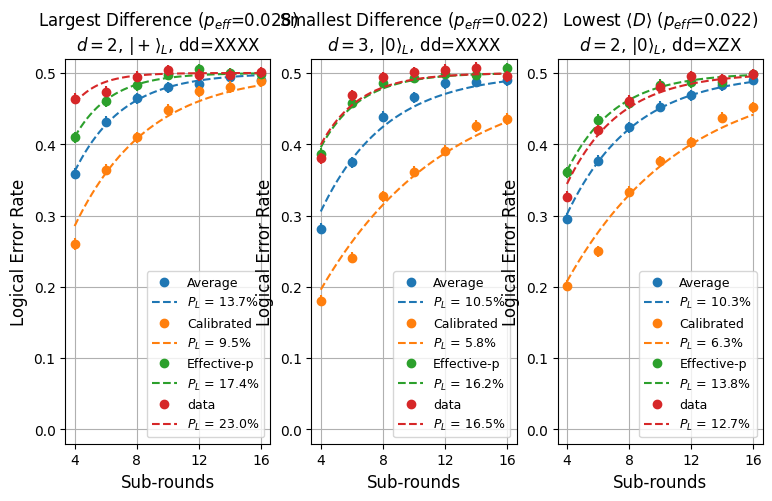

In [29]:
from src.tools import log_er_per_round

titles = ['Largest Difference ','Smallest Difference ',r'Lowest $\langle D\rangle$ ']
labels = ['Average', 'Calibrated','Effective-p','Data']
basis_dict = {"primary":r"$|0\rangle_L$","dual":r"$|+\rangle_L$"}

plt.figure(figsize=(3.*3, 5))

for i,example_index in enumerate(ex_indices):
        real_data = data_set[example_index]
        sim_fits = sim_fits_list[i]

        title = ''

        plt.subplot(130+i+1)
        labels = ['Average', 'Calibrated', 'Effective-p']
        c = 0
        for label in labels:
                plt.plot([key for key in sim_fits[label]['data']], [sim_fits[label]['data'][key] for key in sim_fits[label]['data']], 
                        'o', label=label, color=f'C{c}')
                plt.errorbar([key for key in sim_fits[label]['data']], [sim_fits[label]['data'][key] for key in sim_fits[label]['data']], 
                                yerr=1/np.sqrt(sim_fits[label]['shots']), linestyle=' ', color=f'C{c}')
                # Fitting
                max_sub_rounds = max(real_data['data']['sub_rounds'])
                plt.plot(np.linspace(4, max_sub_rounds, 1000), 
                        log_er_per_round(np.linspace(4, max_sub_rounds, 1000), sim_fits[label]['fit']), 
                        '--', color=f'C{c}', 
                        label='$P_L$ = ' +str(round(100*sim_fits[label]["fit"],1))+'%')
                c += 1
        

        # Labels and real data
        fitting = True

        plt.plot(real_data['data']['sub_rounds'], real_data['data']['error_rates'], 'o', label='data', color=f'C{c}')
        plt.errorbar(real_data['data']['sub_rounds'], real_data['data']['error_rates'], yerr=1/np.sqrt(real_data['data']['shots']), linestyle=' ', color=f'C{c}')

        # Plotting Fits
        if fitting:
                plt.plot(np.linspace(4, max_sub_rounds, 1000), 
                        log_er_per_round(np.linspace(4, max_sub_rounds, 1000), real_data['data']['round_error_rate']), 
                        '--', color=f'C{c}', 
                        label='$P_L$ = ' +str(round(100*real_data["data"]["round_error_rate"],1))+'%'
                        )

        # Nicities
        plt.grid()
        plt.xlabel('Sub-rounds', fontsize = 12)
        plt.ylabel('Logical Error Rate', fontsize = 12)
        plt.xticks([4,8,12,16])
        plt.ylim(-0.02,0.52)
        plt.title(titles[i]+ r'($p_{eff}$='+f"{round(sim_fits['eff_p'], 3)})\n$d={data_set[example_index]['meta_data']['size']}$, {basis_dict[data_set[example_index]['meta_data']['basis']]}, dd={data_set[example_index]['meta_data']['DD']}")
        # plt.hlines(.5, 4, max_sub_rounds + .5, linestyles='dashed', color='gray', label='pure noise')
        plt.legend(loc='lower right', fontsize = 9)
# plt.savefig("paper_images/simulation_comparison_Floquet_examples.pdf", bbox_inches='tight')
plt.show()

## Figure 5: All Simulation Comparison

In [30]:
data_set = rp.get_error_rate_per_round_data(file_name='Results/first_pass_data.json')

shot_noise = 1 / np.sqrt(data_set[0]['data']['shots'])
co = .5 - (2 * shot_noise)
print(co)

cutoff = .475
filtered_set = [data for data in data_set 
                 if data['data']['average_detector_likelihood'] < cutoff]
print(len(data_set), '->', len(filtered_set))

0.484375
80 -> 64


c:\Users\Ian\Downloads\Ian_upload\Ian_upload\src\results_processing.py:424: OptimizeWarning: Covariance of the parameters could not be estimated
  fit, covar = curve_fit(log_er_per_round, sub_rounds, error_rates)


In [203]:
data

{'meta_data': {'date': '20231106',
  'device': 'sherbrooke',
  'size': 3,
  'location': 4,
  'basis': 'primary',
  'DD': 'XXXX'},
 'data': {'sub_rounds': [12, 10, 16, 8, 6, 4, 14],
  'error_rates': [0.4979248046875,
   0.5023193359375,
   0.5078125,
   0.4981689453125,
   0.48089599609375,
   0.4178466796875,
   0.5028076171875],
  'e_likelihood': [0.4598130446213942,
   0.4441410945012019,
   0.45181039663461536,
   0.4451035719651442,
   0.4331852839543269,
   0.4061279296875,
   0.46133188100961536],
  'm_likelihood': [0.467010498046875,
   0.4652850811298077,
   0.4641559307391827,
   0.4658050537109375,
   0.4479827880859375,
   None,
   0.4680011455829327],
  'round_error_rate': 0.19059641101264813,
  'fit_error': 0.006771928421260006,
  'shots': 16384,
  'average_detector_likelihood': 0.45228874612842085}}

In [31]:
calib_points, avg_points, p_eff_points = [], [], []
# fit determines which subround to take <D> from to define p_eff
fit = 16
# Enter points with (real E, sim E, real error, sim error)
i = 0
for data in filtered_set:
    sim_fits = rp.get_simulation_comparison(data, backend="sherbrooke", 
                                            printing=True,
                                            fit_index=fit, alt=True, date_specific=True)
    calib_points.append((data['data']['round_error_rate'],
                         sim_fits['Calibrated']['fit'],
                         data['data']['fit_error'],
                         sim_fits['Calibrated']['error']))
    avg_points.append((data['data']['round_error_rate'],
                         sim_fits['Average']['fit'],
                         data['data']['fit_error'],
                         sim_fits['Average']['error']))
    p_eff_points.append((data['data']['round_error_rate'],
                         sim_fits['Effective-p']['fit'],
                         data['data']['fit_error'],
                         sim_fits['Effective-p']['error']))
    i += 1
    if i % 10 == 0:
        print(i)


Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
10
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
20
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
30
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
40
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
50
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
Siming.......,
60
Siming.......,
Siming.......,
Siming.......,
Siming.......,


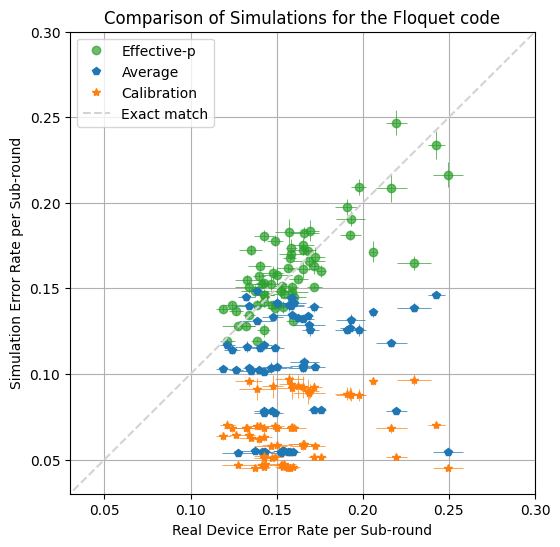

In [33]:
plt.figure(figsize=(6,6))

data_sets = [p_eff_points, avg_points, calib_points]
shapes = ['o', 'p', '*']
alphas = [.7, 1, 1]
labels = ['Effective-p', 'Average', 'Calibration']
for c in range(3):
    real_data, sim_data, real_error, sim_error = np.transpose(data_sets[c])
    plt.plot(real_data, sim_data, shapes[c], color=f'C{(c+2)%3}', label=f"{labels[c]}", alpha=alphas[c])
    plt.errorbar(real_data, sim_data,  xerr = real_error, yerr = sim_error, linestyle=' ', color=f'C{(c+2)%3}', linewidth=.5)


plt.plot(np.linspace(0, .5, 100), np.linspace(0, .5, 100), '--', color='lightgrey', label='Exact match')
plt.ylabel('Simulation Error Rate per Sub-round')
plt.xlabel('Real Device Error Rate per Sub-round')
plt.title(f'Comparison of Simulations for the Floquet code')
plt.xlim(.03, .3)
plt.ylim(.03, .3)
#plt.loglog()
plt.grid(which='both')
plt.legend()
# plt.savefig("paper_images/simulation_comparison_Floquet.pdf")
plt.show()

Now lets do the same for torino data

In [50]:
data_set = rp.get_error_rate_per_round_data(file_name='Results/first_pass_torino.json')

shot_noise = 1 / np.sqrt(data_set[0]['data']['shots'])
co = .5 - (2 * shot_noise)
print(co)

cutoff = .475
filtered_set = [data for data in data_set 
                 if data['data']['average_detector_likelihood'] < cutoff]
print(len(data_set), '->', len(filtered_set))

0.484375
80 -> 80


In [54]:
calib_points, avg_points, p_eff_points = [], [], []
fit = 10
# Enter points with (real E, sim E, real error, sim error)
i = 0
for data in filtered_set:
    sim_fits = rp.get_simulation_comparison(data, backend="torino", printing=True,
                                            fit_index=fit, alt=True, date_specific=True)
    calib_points.append((data['data']['round_error_rate'],
                         sim_fits['Calibrated']['fit'],
                         data['data']['fit_error'],
                         sim_fits['Calibrated']['error']))
    avg_points.append((data['data']['round_error_rate'],
                         sim_fits['Average']['fit'],
                         data['data']['fit_error'],
                         sim_fits['Average']['error']))
    p_eff_points.append((data['data']['round_error_rate'],
                         sim_fits['Effective-p']['fit'],
                         data['data']['fit_error'],
                         sim_fits['Effective-p']['error']))
    i += 1
    if i % 10 == 0:
        print(i)



Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
10
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
20
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
30
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
40
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
50
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
60
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
70
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
Siming....,
80


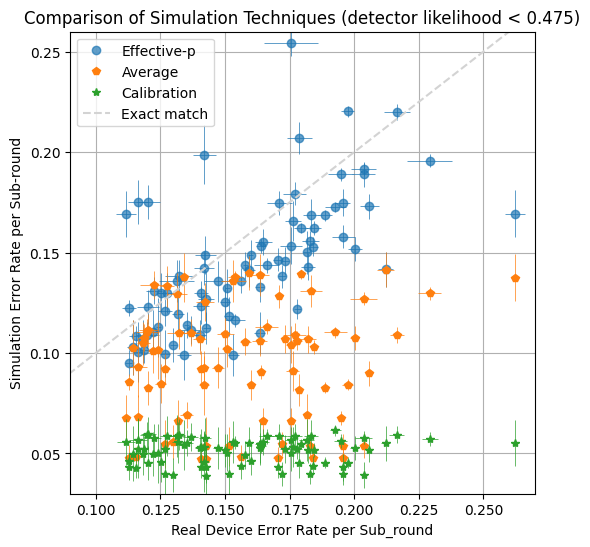

In [56]:
plt.figure(figsize=(6,6))

data_sets = [p_eff_points, avg_points, calib_points]
shapes = ['o', 'p', '*']
alphas = [.7, 1, 1]
labels = ['Effective-p', 'Average', 'Calibration']
for c in range(3):
    real_data, sim_data, real_error, sim_error = np.transpose(data_sets[c])
    plt.plot(real_data, sim_data, shapes[c], color=f'C{c}', label=f"{labels[c]}", alpha=alphas[c])
    plt.errorbar(real_data, sim_data, real_error, sim_error, linestyle=' ', color=f'C{c}', linewidth=.5)


plt.plot(np.linspace(0, .5, 100), np.linspace(0, .5, 100), '--', color='lightgrey', label='Exact match')
plt.ylabel('Simulation Error Rate per Sub-round')
plt.xlabel('Real Device Error Rate per Sub_round')
plt.title(f'Comparison of Simulation Techniques (detector likelihood < {cutoff})')
plt.xlim(.09, .27)
plt.ylim(.03, .26)
#plt.loglog()
plt.grid(which='both')
plt.legend()
plt.show()

## Figure 6: Threshold Surface

Taking data from previously done sim.

In [34]:
f = open('simulation_data/threshold_surface_thresholds_g=15_nofail.json', 'r')
threshold_data = json.load(f)
f.close()

In [35]:
threshold_points = threshold_data["data"]

In [218]:
# threshold_points

In [37]:
heat_data = []
threshold_points2 = []
print(len(threshold_points))
for i in range(len(threshold_points)):
    # Defining noise breakdown
    x, y, z = (threshold_points[i])
    # if x<0 or y<0 or z<0 or x>0.01 or y>0.01 or z>0.01:
    #     # print([z, x, z, 1e-4, y]/np.linalg.norm([z, x, z, 1e-4, y]))
    #     x,y,z = 0,0,0
    # else:
    noises = [z, x, z, 1e-4, y]
    threshold_points2.append(threshold_points[i])

    # Defining weather circuit
    layout = templates.diamond(5, noise=noises)
    hex_code = Hex_Code(layout, sub_rounds=16)

    # Running sim
    detectors = hex_code.sample(2**12)[0]
    heat_data.append(rp.get_em_heatmaps(hex_code, detectors,include_spatial_truncs=False,include_timelike_truncs=False))
    print('.', end='')
    if i % 50 == 0:
        print(i)
print(i)

136
.0
..................................................50
..................................................100
...................................135


In [38]:
# Check heat data is actually e_heat, might need to split. 
e_avgs = [sum([entry[0][key] for key in entry[0]]) / len(entry[0]) 
          for entry in heat_data]
#len(e_avgs), len(threshold_points)
# e_avgs
threshold_points = threshold_points2

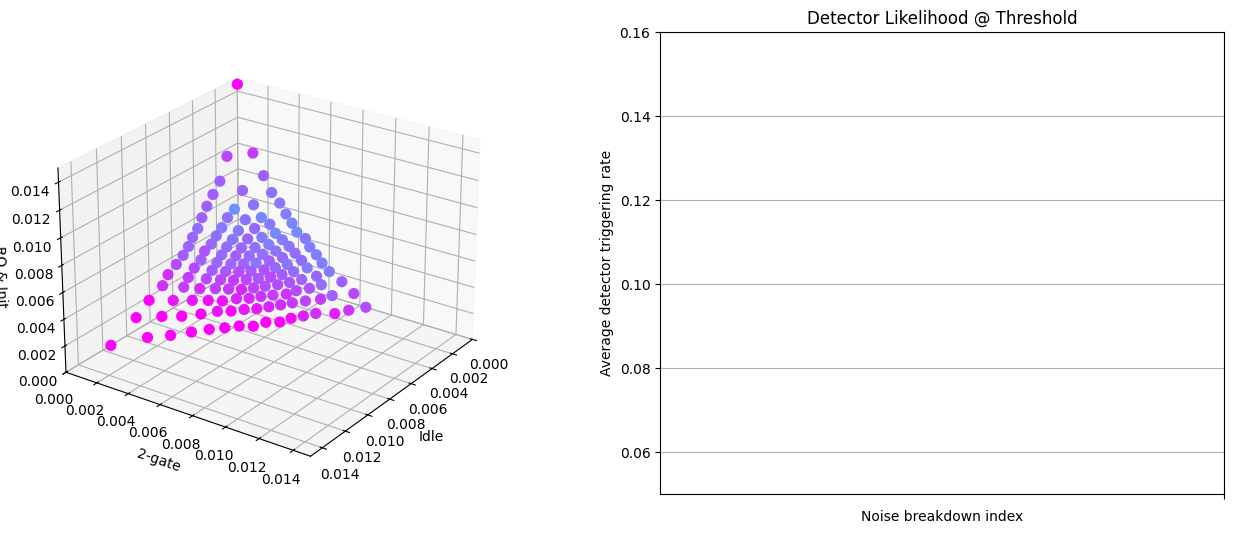

In [39]:
fig = plt.figure(figsize=(16,6), )

ax = fig.add_subplot(1, 2, 1, projection='3d', )


xs, ys, zs = np.transpose(threshold_points)

# Setting color
cmap = mpl.colormaps['cool']
ax.scatter(xs, ys, zs, 'o', color=[cmap((h - .08) / .05) for h in e_avgs], s=50, alpha=1, zorder=-1)

# Values we care about
# forward = 1
# ax.scatter(forward*flat_thresh/np.sqrt(3), forward*flat_thresh/np.sqrt(3), forward*flat_thresh/np.sqrt(3), 
#            'o', color='red', zorder=3, s=100)
# correction = 1.8
# ax.scatter(sher_threshold_point[0]/correction, 
#            sher_threshold_point[1]/correction, 
#            sher_threshold_point[2]/correction, 
#            'o', color='tab:orange', s=100)

ax.set_xlabel('Idle')
ax.set_ylabel('2-gate')
ax.set_zlabel('RO & Init')
ax.set_xlim(0,.015)
ax.set_ylim(0,.015)
ax.set_zlim(0,.015)
ax.view_init(25,35)

ax1 = fig.add_subplot(1, 2, 2)

# ax1.violinplot(e_avgs, [1],
#                showextrema=False,
#                showmedians=True,
#     [range(len(threshold_points))], e_avgs, 'o', label='e detectors', color='tab:blue')
# ax1.scatter(1, sher_e_avg, label='ibm_sherbrooke')
# ax1.scatter(1, flat_e_avg, label='flat noise model')

ax1.set_xlabel('Noise breakdown index')
ax1.set_ylabel('Average detector triggering rate')
ax1.set_xticks([1], [''])
ax1.set_ylim(.05, .16)
ax1.grid()
ax1.set_title('Detector Likelihood @ Threshold')

plt.show()

In [40]:
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform

# class Arrow3D(FancyArrowPatch):
#     def __init__(self, xs, ys, zs, *args, **kwargs):
#         super().__init__((0,0), (0,0), *args, **kwargs)
#         self._verts3d = xs, ys, zs

#     def do_3d_projection(self):
#         xs3d, ys3d, zs3d = self._verts3d
#         xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
#         self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

#         return np.min(zs)

	
class Arrow3D(FancyArrowPatch):

    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (xs[0], ys[0], zs[0])
        self._dxdydz = (xs[1]-xs[0], ys[1]-ys[0], zs[1]-zs[0])

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs)

def vec_below_above_threshold(vec,th_points):
    vec_norm = vec/np.linalg.norm(vec)
    #finding the closest direction
    th_overlaps = [np.dot(vec_norm,th_vec/np.linalg.norm(th_vec)) for th_vec in th_points]
    closest_th_ind = np.argmax(th_overlaps)
    th_value = np.linalg.norm(th_points[closest_th_ind])
    vec_below = np.transpose([[0,0,0],th_value*vec_norm])
    vec_above = np.transpose([th_value*vec_norm,vec])
    return vec_below,vec_above

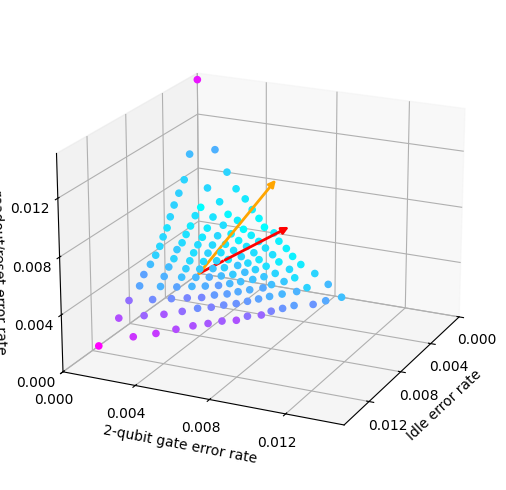

In [41]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111,projection='3d')


#arrow part behind the surface
flat_vec_below, flat_vec_above = vec_below_above_threshold([.01,.01,.01],threshold_points)
sherbrooke_errors = [1.244/160.63,8.228e-3,1.200e-2]
sherb_vec_below, sherb_vec_above = vec_below_above_threshold(sherbrooke_errors,threshold_points)
ax.plot(*flat_vec_below,lw=2,color='red',zorder=-1)
ax.plot(*sherb_vec_below,lw=2,color='orange',zorder=-1)


#the surface
xs, ys, zs = np.transpose(threshold_points)
cmap = mpl.colormaps['cool']
ax.scatter(xs, ys, zs, 'o', 
           color=[cmap((h -  min(e_avgs)) / (max(e_avgs) - min(e_avgs))) for h in e_avgs], 
           s=20, alpha=1,zorder = 0)

#arrow part outside the surface
a = Arrow3D(*flat_vec_above, mutation_scale=10, 
            lw=2, arrowstyle="-|>", color="red")
b = Arrow3D(*sherb_vec_above, mutation_scale=10, 
            lw=2, arrowstyle="-|>", color="orange")
ax.add_artist(a)
ax.add_artist(b)

ax.set_xticks(np.linspace(0,0.016,5))
ax.set_yticks(np.linspace(0,0.016,5))
ax.set_zticks(np.linspace(0,0.016,5))

axis_lim = .015
ax.set_xlim(0, axis_lim)
ax.set_ylim(0, axis_lim)
ax.set_zlim(0, axis_lim)


ax.view_init(elev=20, azim=25)
ax.set_xlabel('Idle error rate')
ax.set_ylabel('2-qubit gate error rate')
ax.set_zlabel('readout/reset error rate')

plt.tight_layout()
# plt.savefig('paper_images/Floquet_threshold_surface.pdf', bbox_inches = 'tight',pad_inches=0.3)
plt.show()

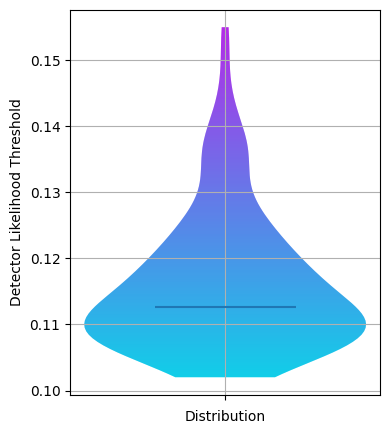

In [42]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch

# fig, ax = plt.figure(fig_size=(6,4))
fig = plt.figure(figsize=(4,5))
ax = fig.add_subplot(111)

violin = ax.violinplot(e_avgs,[1],
               showextrema=False,
               showmedians=True,)

ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()

# create a numpy image to use as a gradient
Nx,Ny=1,1000
imgArr = np.tile(np.linspace(0,1,Ny), (Nx,1)).T
cmap = 'cool'

ax.grid()

violin = violin['bodies'][0]
path = Path(violin.get_paths()[0].vertices)
patch = PathPatch(path, facecolor='none', edgecolor='none')
ax.add_patch(patch)
img = ax.imshow(imgArr, origin="lower", extent=[xmin,xmax,ymin,ymax], aspect="auto",
                cmap=cmap,
                clip_path=patch)

ax.set_xlabel('Distribution')
ax.set_ylabel('Detector Likelihood Threshold')
ax.set_xticks([1], [''])
# plt.savefig('paper_images/Floquet_threshold_surface_violin.pdf', bbox_inches = 'tight',pad_inches = .5)
plt.show()